# ARIMA 간략
### I항 비정상 차이에 대한 적분과 오류항에 대한 이동평균 MA,자동회귀(AR)항 이전값의 시차

# facebook 은 prophet 이라는 패키지가 있다. 자동적으로 많은것을 고려해줌 

In [1]:
import warnings 
warnings.filterwarnings('ignore')
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
import statsmodels.api as sm

color = sns.color_palette()
sns.set_style('darkgrid')

In [2]:
train = pd.read_csv('../input/demand-forecasting-kernels-only/train.csv')
train['date'] = pd.to_datetime(train['date'], format="%Y-%m-%d")

train.head()


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


## I항은 오늘의 가치에서 어제의 가치를 뺀것

In [3]:
# per 1 store, 1 item
train_df = train[train['store']==1]
train_df = train_df[train['item']==1]
# train_df = train_df.set_index('date')
train_df['year'] = train['date'].dt.year
train_df['month'] = train['date'].dt.month
train_df['day'] = train['date'].dt.dayofyear
train_df['weekday'] = train['date'].dt.weekday

train_df.head()

,date,store,item,sales,year,month,day,weekday
0,2013-01-01,1,1,13,2013,1,1,1
1,2013-01-02,1,1,11,2013,1,2,2
2,2013-01-03,1,1,14,2013,1,3,3
3,2013-01-04,1,1,13,2013,1,4,4
4,2013-01-05,1,1,10,2013,1,5,5


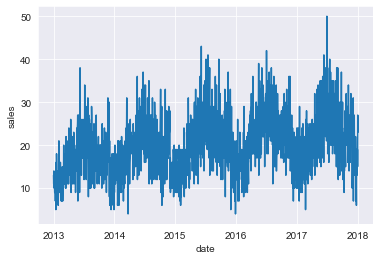

In [4]:
sns.lineplot(x="date", y="sales",legend = 'full' , data=train_df)

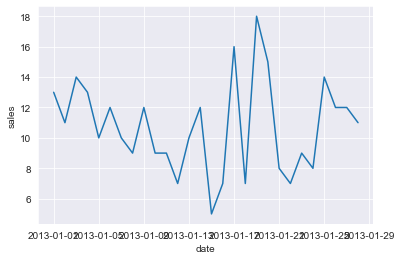

In [5]:
sns.lineplot(x="date", y="sales",legend = 'full' , data=train_df[:28])

## 월요일은 0 , 일요일은 6 월~금은 좀 낮고 토일이 더높다. 

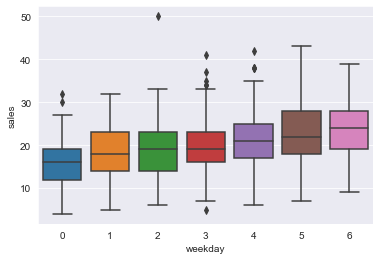

In [6]:
sns.boxplot(x="weekday", y="sales", data=train_df)

# 인덱스를 날짜로 설정하기

In [7]:
train_df = train_df.set_index('date')
train_df['sales'] = train_df['sales'].astype(float)

train_df.head()

,store,item,sales,year,month,day,weekday
date,,,,,,,
2013-01-01,1,1,13.0,2013,1,1,1
2013-01-02,1,1,11.0,2013,1,2,2
2013-01-03,1,1,14.0,2013,1,3,3
2013-01-04,1,1,13.0,2013,1,4,4
2013-01-05,1,1,10.0,2013,1,5,5


<Figure size 432x288 with 0 Axes>

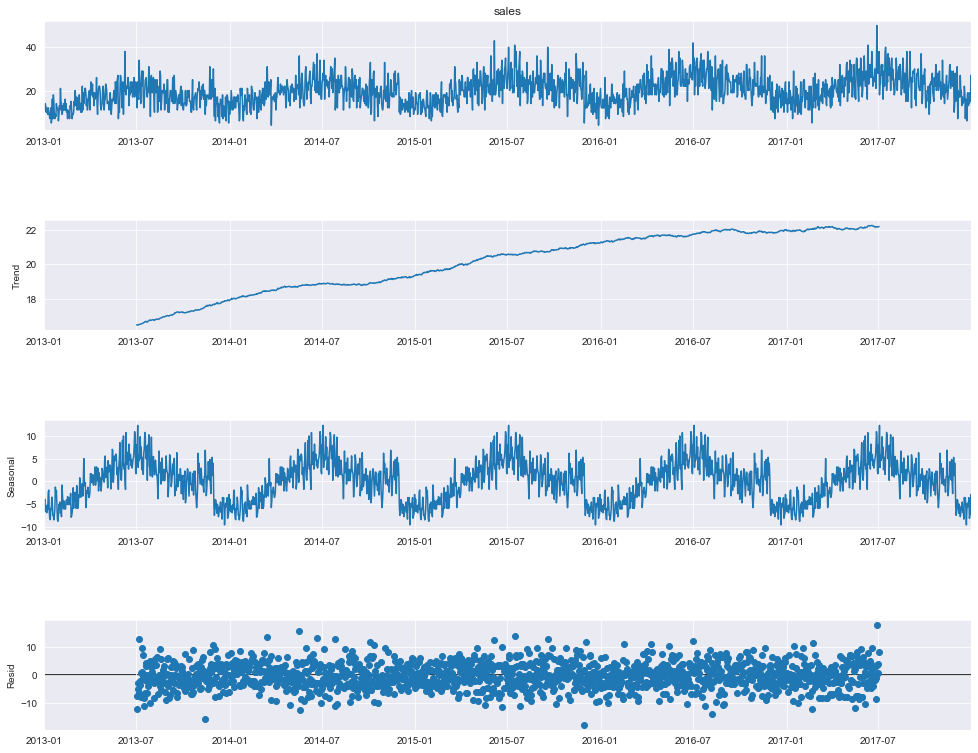

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(train_df['sales'], model='additive', freq=365)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)

# 눈으로봐도 명백하게 연도 패턴이 있고 점점 증가하는 트렌드가 있다. stationary하지 않다. 

# Dickey-Fuller test .
## Test Statistic 이 Critical Value 보다 크면 시계열은 안정적이라고 할수있다. 확인해보자

In [9]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    # 이동하는데 12로 잡는다.
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

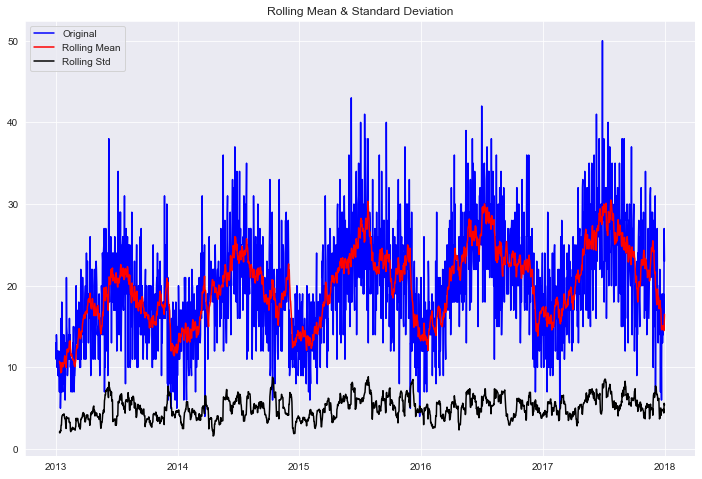

Results of Dickey-Fuller Test:
p-value = 0.0361. The series is likely non-stationary.
Test Statistic                   -2.987278
p-value                           0.036100
#Lags Used                       20.000000
Number of Observations Used    1805.000000
Critical Value (1%)              -3.433978
Critical Value (5%)              -2.863143
Critical Value (10%)             -2.567623
dtype: float64


In [10]:
test_stationarity(train_df['sales'])

# p값이 작을수록 stationary 일 가능성이 높다. 0.03이다 나쁘지않다. 5% 를 사용하면 안정적이라고 할수있다. test statistic때문에. 로그나 차분을 이용하는 방법도 있다. 

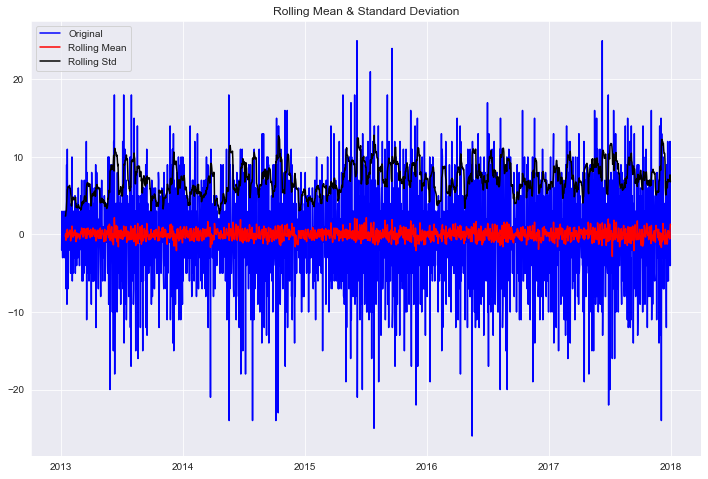

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.520810e+01
p-value                        5.705031e-28
#Lags Used                     2.000000e+01
Number of Observations Used    1.804000e+03
Critical Value (1%)           -3.433980e+00
Critical Value (5%)           -2.863143e+00
Critical Value (10%)          -2.567624e+00
dtype: float64


In [11]:
first_diff = train_df.sales - train_df.sales.shift(1)
first_diff = first_diff.dropna(inplace = False)
test_stationarity(first_diff, window = 12)


# p value가 엄청 작아졌다 안정적이다. 

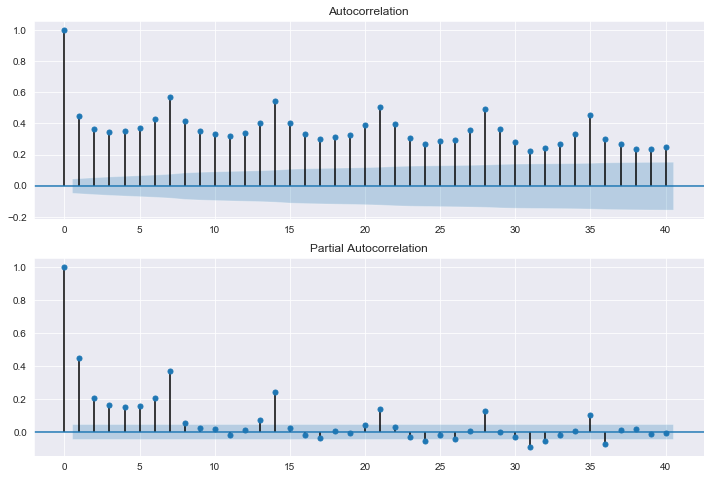

In [12]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_df.sales, lags=40, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_df.sales, lags=40, ax=ax2)# , lags=40

# 차분한것과 안한것의 차이 

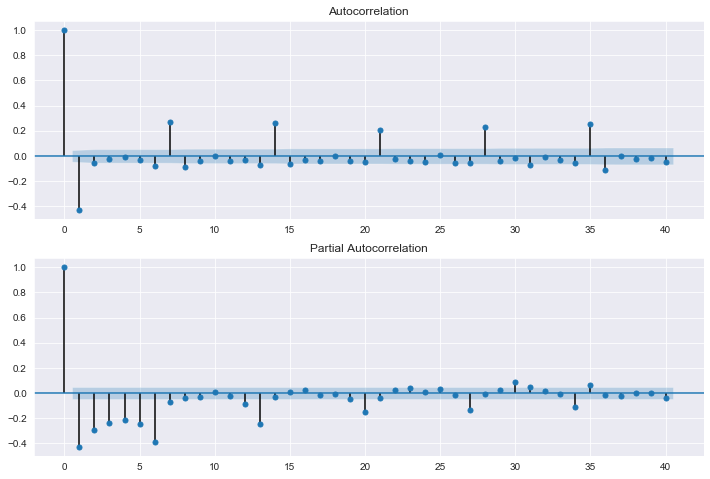

In [13]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, lags=40, ax=ax2)

## period 7 마다  반복되는 패턴이 보입니다. 주간 패턴이 존재한다고 알수있다. 

# 자기상관이 7, 14, 21 마다 음수이므로 SMA항을 해야한다. 

# i항은 1차 차분이 안정st이므로 1이다.
# ar은 6시차 이다. pacf 로 부터 

In [14]:
arima_mod6 = sm.tsa.ARIMA(train_df.sales, (6,1,0)).fit(disp=False)
print(arima_mod6.summary())

C:\Users\acorn\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\acorn\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                 1825
Model:                 ARIMA(6, 1, 0)   Log Likelihood               -5597.668
Method:                       css-mle   S.D. of innovations              5.195
Date:                Thu, 27 Aug 2020   AIC                          11211.335
Time:                        16:40:16   BIC                          11255.410
Sample:                    01-02-2013   HQIC                         11227.594
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0039      0.025      0.152      0.879      -0.046       0.054
ar.L1.D.sales    -0.8174      0.022    -37.921      0.000      -0.860      -0.775
ar.L2.D.sales    -0.7497      0.026    -

# 모델의 성능을 확인하기위해 잔차 분표를 그린다. 

NormaltestResult(statistic=16.426386182016387, pvalue=0.0002710538384339186)


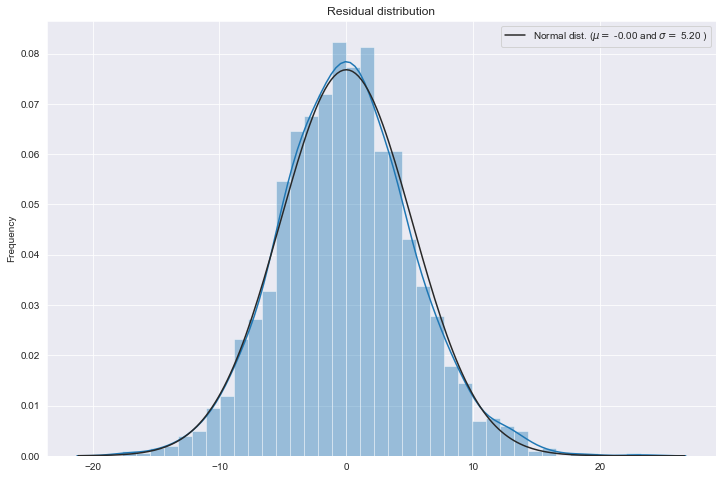

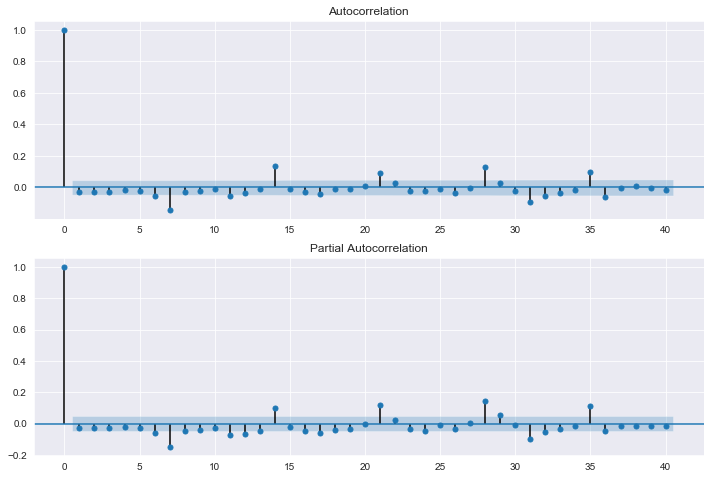

In [15]:
from scipy import stats
from scipy.stats import normaltest

resid = arima_mod6.resid
print(normaltest(resid))
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod6.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod6.resid, lags=40, ax=ax2)

# 그래프는 정규분포이고 테스트는 실패했다. acf, pacf 에 반복되는 상관관계가 존재한다. 계절성을 적용해야한다. 

In [16]:
sarima_mod6 = sm.tsa.statespace.SARIMAX(train_df.sales, trend='n', order=(6,1,0)).fit()
print(sarima_mod6.summary())

C:\Users\acorn\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\acorn\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1826
Model:               SARIMAX(6, 1, 0)   Log Likelihood               -5597.679
Date:                Thu, 27 Aug 2020   AIC                          11209.359
Time:                        16:43:12   BIC                          11247.924
Sample:                    01-01-2013   HQIC                         11223.585
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8174      0.021    -39.063      0.000      -0.858      -0.776
ar.L2         -0.7497      0.025    -30.480      0.000      -0.798      -0.702
ar.L3         -0.6900      0.026    -26.686      0.0

NormaltestResult(statistic=16.74269015097355, pvalue=0.00023140408834604307)


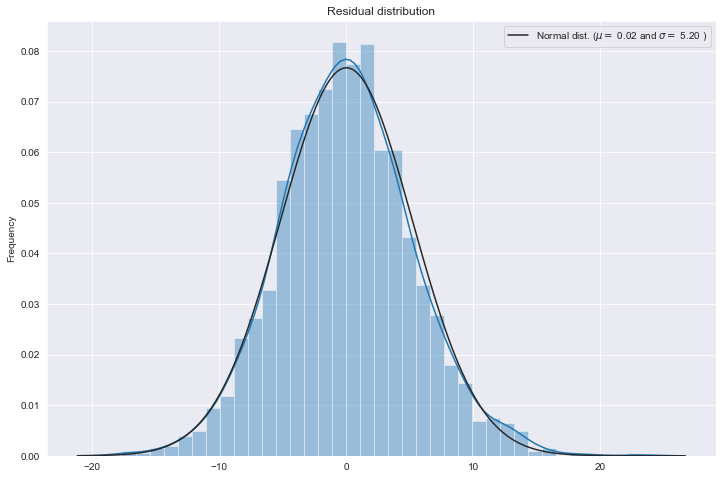

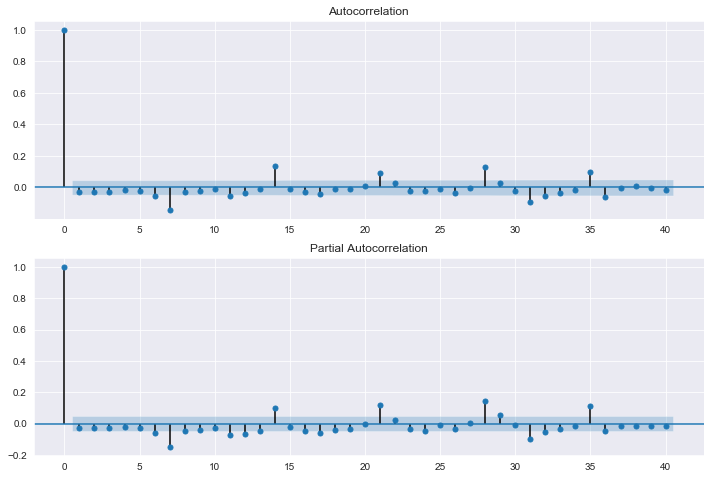

In [17]:
resid = sarima_mod6.resid
print(normaltest(resid))

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod6.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod6.resid, lags=40, ax=ax2)

# 예측과 평가 최신 30일의 트레이닝셋을 검증데이터로

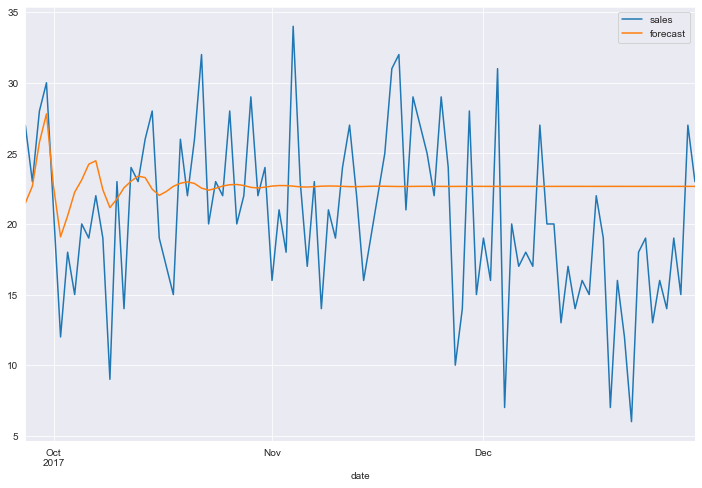

In [18]:
start_index = 1730
end_index = 1826
train_df['forecast'] = sarima_mod6.predict(start = start_index, end= end_index, dynamic= True)  
train_df[start_index:end_index][['sales', 'forecast']].plot(figsize=(12, 8))

In [19]:
def smape_kun(y_true, y_pred):
    mape = np.mean(abs((y_true-y_pred)/y_true))*100
    smape = np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))).fillna(0))
    print('MAPE: %.2f %% \nSMAPE: %.2f'% (mape,smape), "%")

In [20]:
smape_kun(train_df[1730:1825]['sales'],train_df[1730:1825]['forecast'])

MAPE: 33.01 % 
SMAPE: 25.07 %


In [21]:
# per 1 store, 1 item
storeid = 1
itemid = 1
train_df = train[train['store']==storeid]
train_df = train_df[train_df['item']==itemid]

# train_df = train_df.set_index('date')
train_df['year'] = train_df['date'].dt.year - 2012
train_df['month'] = train_df['date'].dt.month
train_df['day'] = train_df['date'].dt.dayofyear
train_df['weekday'] = train_df['date'].dt.weekday

start_index = 1730
end_index = 1826

# train_df.head()